In [4]:
#Downloading the dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pkiransai","key":"0743bd6a3afcd627901a2cfbe4c81fcd"}'}

In [6]:

#Downloading the dataset



!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip


mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 811M/812M [00:38<00:00, 22.4MB/s]
100% 812M/812M [00:38<00:00, 22.3MB/s]


Copying images to training, validation, and test directories

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

Question 1:- Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (half the sample size as the sample Jupyter notebook on Canvas). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

Let's train a model from scratch. The model 1 has a Training sample of 1000, a validation sample of 500, and a test sample of 500

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Epoch 1/50
63/63 [==============================] - 7s 77ms/step - loss: 0.7049 - accuracy: 0.5315 - val_loss: 0.6894 - val_accuracy: 0.5080
Epoch 2/50
63/63 [==============================] - 5s 73ms/step - loss: 0.6896 - accuracy: 0.5470 - val_loss: 0.6782 - val_accuracy: 0.6120
Epoch 3/50
63/63 [==============================] - 6s 88ms/step - loss: 0.6774 - accuracy: 0.5880 - val_loss: 0.6567 - val_accuracy: 0.6400
Epoch 4/50
63/63 [==============================] - 5s 74ms/step - loss: 0.6413 - accuracy: 0.6370 - val_loss: 0.6181 - val_accuracy: 0.6760
Epoch 5/50
63/63 [==============================] - 5s 77ms/step - loss: 0.6108 - accuracy: 0.6695 - val_loss: 0.6006 - val_accuracy: 0.6750
Epoch 6/50
63/63 [==============================] - 5s 65ms/step - loss: 0.5781 - accuracy: 0.7040 - val_loss: 0.6046 - val_accuracy: 0.6590
Epoch 7/50
63/63 [==============================] - 4s 59ms/step - loss: 0.5305 - accuracy: 0.7340 - val_loss: 0.6023 - val_accuracy: 0.6800
Epoch 8/50
63

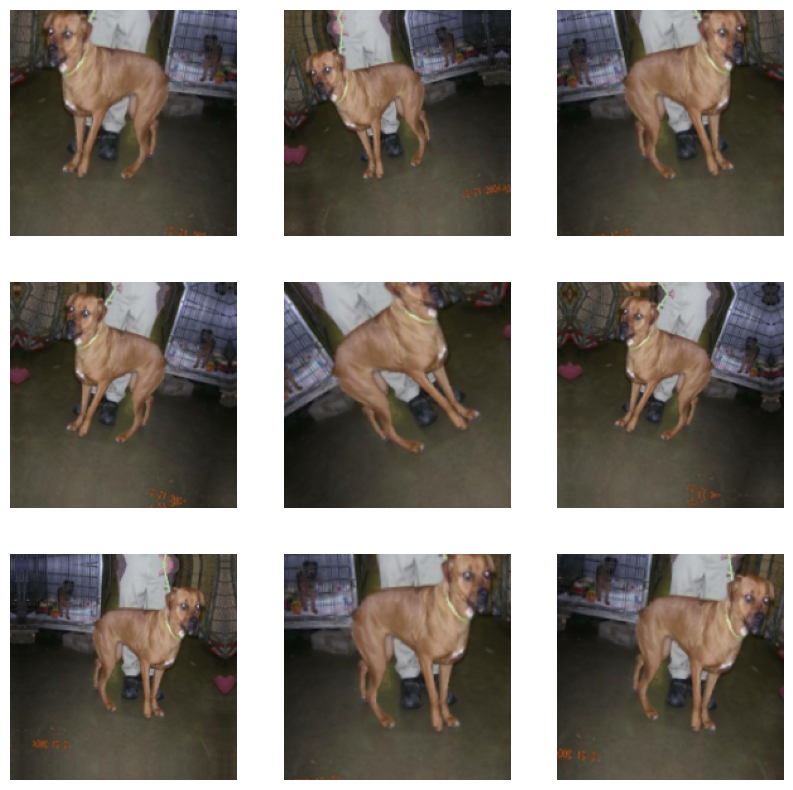

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


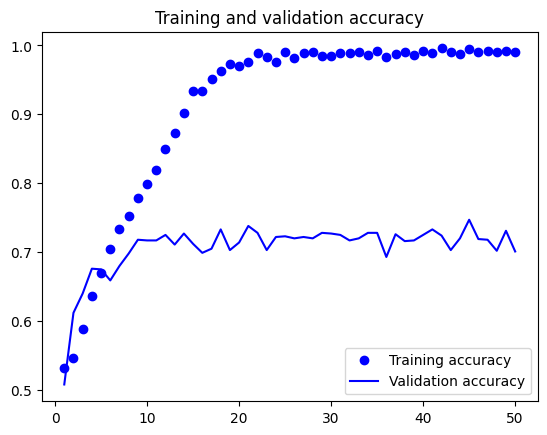

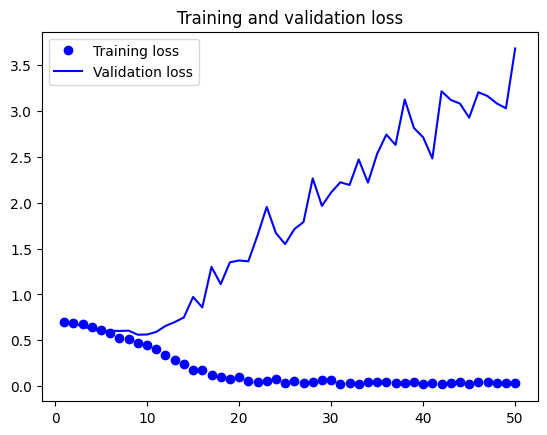

In [13]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Question 2: Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

The second model we are increasing training sample and keeping validation sample of 500, and a test sample of 500.

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_2", start_index=0, end_index=3000)
make_subset("validation_2", start_index=3000, end_index=3500)
make_subset("test_2", start_index=3500, end_index=4000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Epoch 1/50
188/188 [==============================] - 13s 61ms/step - loss: 0.8492 - accuracy: 0.5202 - val_loss: 0.6975 - val_accuracy: 0.5050
Epoch 2/50
188/188 [==============================] - 11s 58ms/step - loss: 0.6661 - accuracy: 0.5957 - val_loss: 0.6542 - val_accuracy: 0.6100
Epoch 3/50
188/188 [==============================] - 11s 59ms/step - loss: 0.6266 - accuracy: 0.6620 - val_loss: 0.5995 - val_accuracy: 0.6920
Epoch 4/50
188/188 [==============================] - 11s 59ms/step - loss: 0.6066 - accuracy: 0.6840 - val_loss: 0.5876 - val_accuracy: 0.6980
Epoch 5/50
188/188 [==============================] - 10s 53ms/step - loss: 0.5930 - accuracy: 0.6947 - val_loss: 0.5973 - val_accuracy: 0.6800
Epoch 6/50
188/188 [==============================] - 11s 58ms/step - loss: 0.5841 - accuracy: 0.7023 - val_loss: 0.5706 - val_accuracy: 0.7200
Epoch 7/50
188/188 [==============================] - 11s 56ms/step - loss: 0.5668 - accuracy: 0.7157 - val_loss: 0.5854 - val_accuracy:

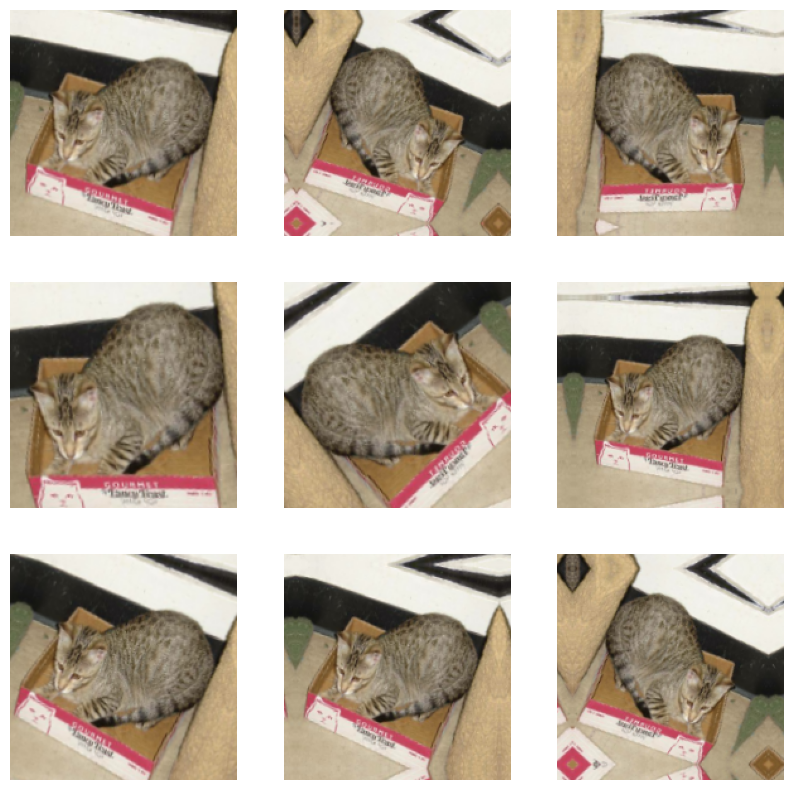

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)






test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


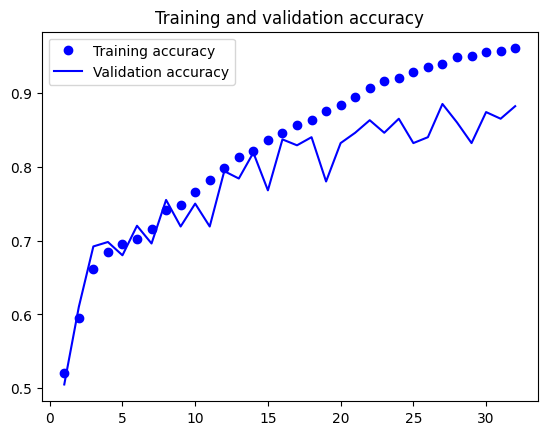

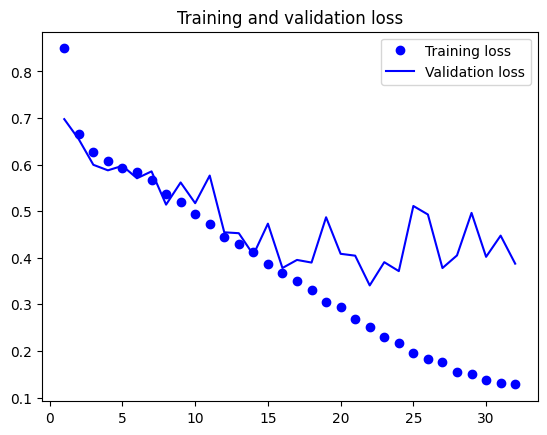

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Question 3 :- Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Now, the third model will have 9000 training samples we will keep the same validation sample of 500, and a test sample of 500.



In [17]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_3", start_index=0, end_index=9000)
make_subset("validation_3", start_index=9000, end_index=9500)
make_subset("test_3", start_index=9500, end_index=10000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 18000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Epoch 1/50
563/563 [==============================] - 30s 51ms/step - loss: 0.7214 - accuracy: 0.5785 - val_loss: 0.5879 - val_accuracy: 0.7040
Epoch 2/50
563/563 [==============================] - 27s 48ms/step - loss: 0.6005 - accuracy: 0.6886 - val_loss: 0.6827 - val_accuracy: 0.6050
Epoch 3/50
563/563 [==============================] - 29s 52ms/step - loss: 0.5636 - accuracy: 0.7151 - val_loss: 0.5244 - val_accuracy: 0.7430
Epoch 4/50
563/563 [==============================] - 31s 55ms/step - loss: 0.5151 - accuracy: 0.7562 - val_loss: 0.5074 - val_accuracy: 0.7660
Epoch 5/50
563/563 [==============================] - 29s 51ms/step - loss: 0.4692 - accuracy: 0.7868 - val_loss: 0.4805 - val_accuracy: 0.7930
Epoch 6/50
563/563 [==============================] - 29s 50ms/step - loss: 0.4246 - accuracy: 0.8134 - val_loss: 0.4051 - val_accuracy: 0.8380
Epoch 7/50
563/563 [==============================] - 27s 48ms/step - loss: 0.3916 - accuracy: 0.8334 - val_loss: 0.4117 - val_accuracy:

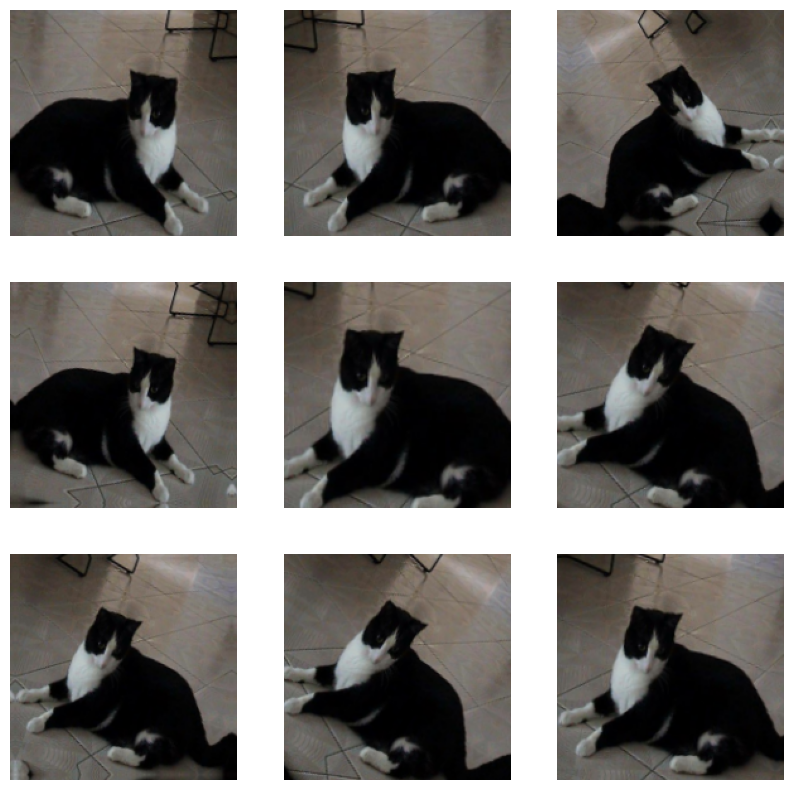

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)




test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


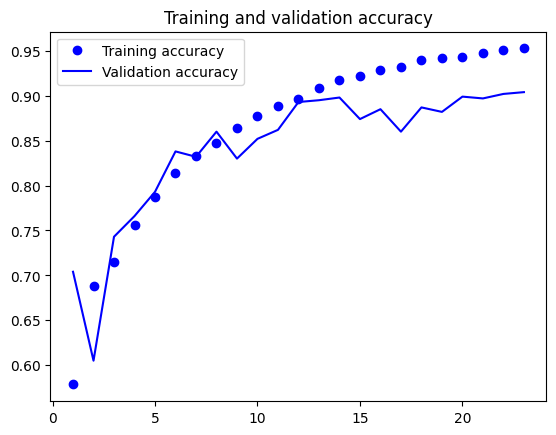

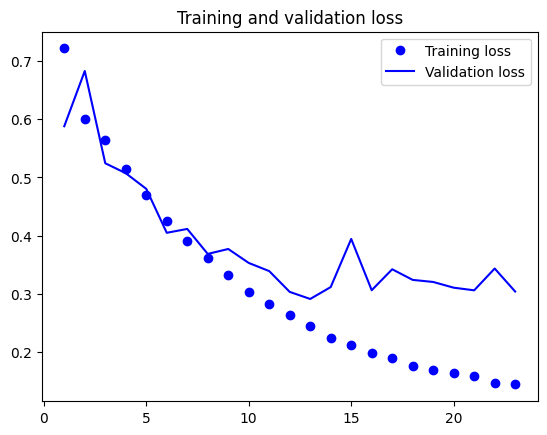

In [19]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Question 4 :- Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Pretrained Model1:- Training sample of 2000, a validation sample of 1000, and a test sample of 1000.

VGG16 Pretrained Convnet Network

Using Feature Extraction with Data Augmentation and Fine-tuning

Epoch 1/50
563/563 [==============================] - 29s 51ms/step - loss: 0.1395 - accuracy: 0.9549 - val_loss: 0.3464 - val_accuracy: 0.9020
Epoch 2/50
563/563 [==============================] - 32s 56ms/step - loss: 0.1384 - accuracy: 0.9552 - val_loss: 0.3250 - val_accuracy: 0.8990
Epoch 3/50
563/563 [==============================] - 27s 48ms/step - loss: 0.1336 - accuracy: 0.9596 - val_loss: 0.3905 - val_accuracy: 0.8820
Epoch 4/50
563/563 [==============================] - 28s 49ms/step - loss: 0.1275 - accuracy: 0.9610 - val_loss: 0.3559 - val_accuracy: 0.9090
Epoch 5/50
563/563 [==============================] - 29s 51ms/step - loss: 0.1232 - accuracy: 0.9622 - val_loss: 0.4039 - val_accuracy: 0.8910
Epoch 6/50
563/563 [==============================] - 27s 48ms/step - loss: 0.1246 - accuracy: 0.9614 - val_loss: 0.3962 - val_accuracy: 0.8810
Epoch 7/50
563/563 [==============================] - 27s 48ms/step - loss: 0.1261 - accuracy: 0.9626 - val_loss: 0.3503 - val_accuracy:

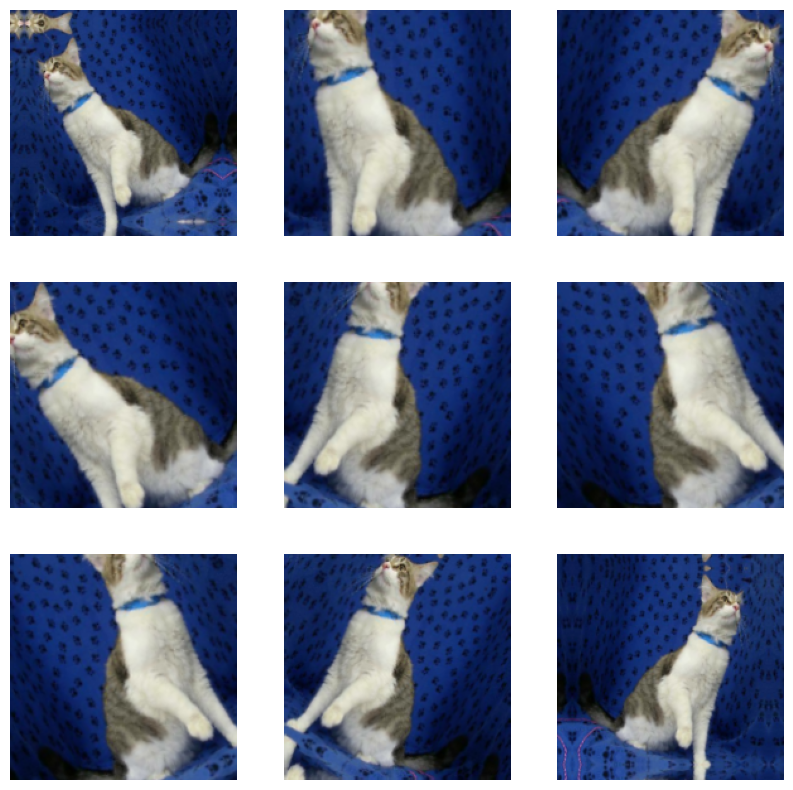

32/32 [==============================] - 1s 34ms/step - loss: 0.2886 - accuracy: 0.9040
Test accuracy: 0.904


In [21]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_1 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()

test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


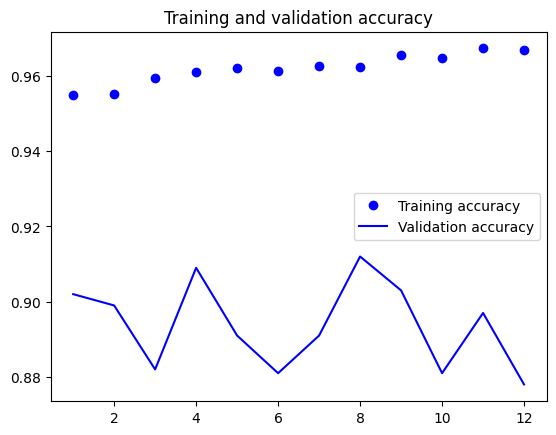

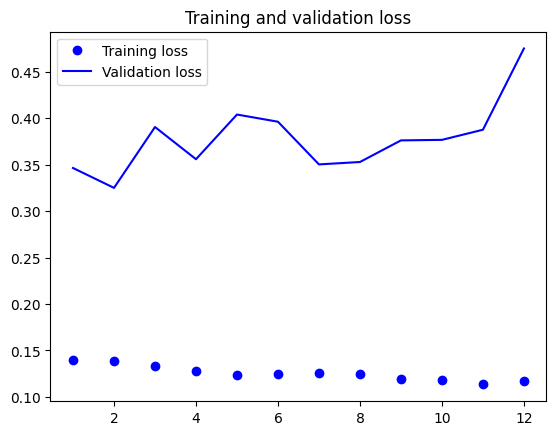

In [22]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
563/563 [==============================] - 85s 141ms/step - loss: 0.2311 - accuracy: 0.9489 - val_loss: 0.1563 - val_accuracy: 0.9770
Epoch 2/50
563/563 [==============================] - 74s 131ms/step - loss: 0.1768 - accuracy: 0.9661 - val_loss: 0.1267 - val_accuracy: 0.9880
Epoch 3/50
563/563 [==============================] - 52s 92ms/step - loss: 0.1552 - accuracy: 0.9716 - val_loss: 0.1594 - val_accuracy: 0.9770
Epoch 4/50
563/563 [==============================] - 53s 93ms/step - loss: 0.1490 - accuracy: 0.9737 - val_loss: 0.1478 - val_accuracy: 0.9790
Epoch 5/50
563/563 [==============================] - 56s 98ms/step - loss: 0.1278 - accuracy: 0.9772 - val_loss: 0.1867 - val_accuracy: 0.9810
Epoch 6/50
563/563 [==============================] - 53s 93ms/step - loss: 0.1254 - accuracy: 0.9782 - val_loss: 0.1314 - val_accuracy: 0.9850
Epoch 7/50
563/563 [==============================] - 53s 95ms/step -

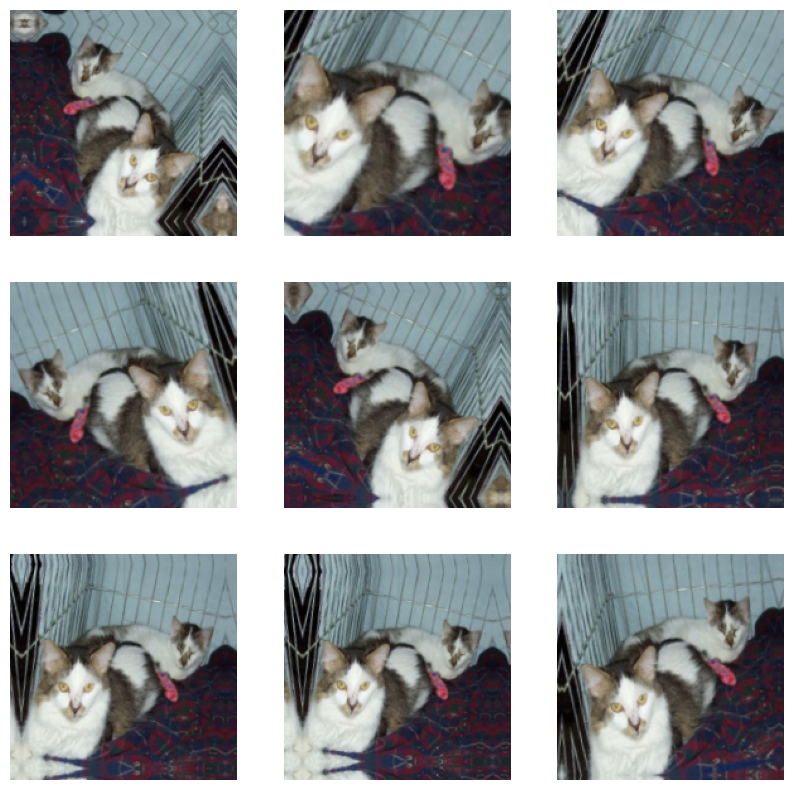

32/32 [==============================] - 4s 76ms/step - loss: 0.1297 - accuracy: 0.9760
Test accuracy: 0.976


In [24]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50

# Instantiating the ResNet50 convolutional base
conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(180, 180, 3))

# Freezing all layers until the fifth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_2 = keras.Model(inputs, outputs)

# Fine-tuning the model
model_pre_trained_2.compile(loss="binary_crossentropy",
                            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                            metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]

history = model_pre_trained_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()


test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


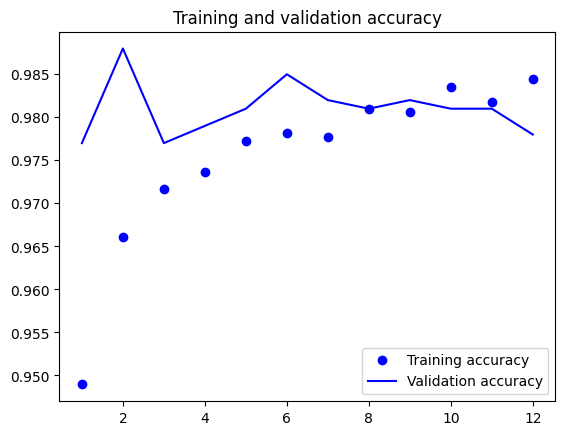

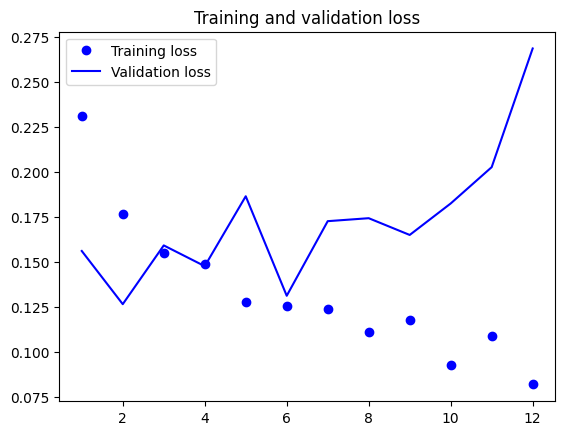

In [25]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/50
563/563 [==============================] - 49s 79ms/step - loss: 0.6459 - accuracy: 0.6959 - val_loss: 0.2580 - val_accuracy: 0.8880
Epoch 2/50
563/563 [==============================] - 44s 77ms/step - loss: 0.3586 - accuracy: 0.8513 - val_loss: 0.1416 - val_accuracy: 0.9530
Epoch 3/50
563/563 [==============================] - 46s 82ms/step - loss: 0.2583 - accuracy: 0.8984 - val_loss: 0.1080 - val_accuracy: 0.9640
Epoch 4/50
563/563 [==============================] - 47s 84ms/step - loss: 0.2118 - accuracy: 0.9198 - val_loss: 0.0922 - val_accuracy: 0.9700
Epoch 5/50
563/563 [==============================] - 44s 78ms/step - loss: 0.1915 - accuracy: 0.9301 - val_loss: 0.0830 - val_accuracy: 0.9720
Epoch 6/50
563/563 [==============================] - 43s 77ms/step - loss: 0.1834 - accuracy: 0.9321 - val_loss: 0.0774 - val_accuracy: 0.9730
Epoch 7/50
563/563 [==============================] - 44s 78ms/step - los

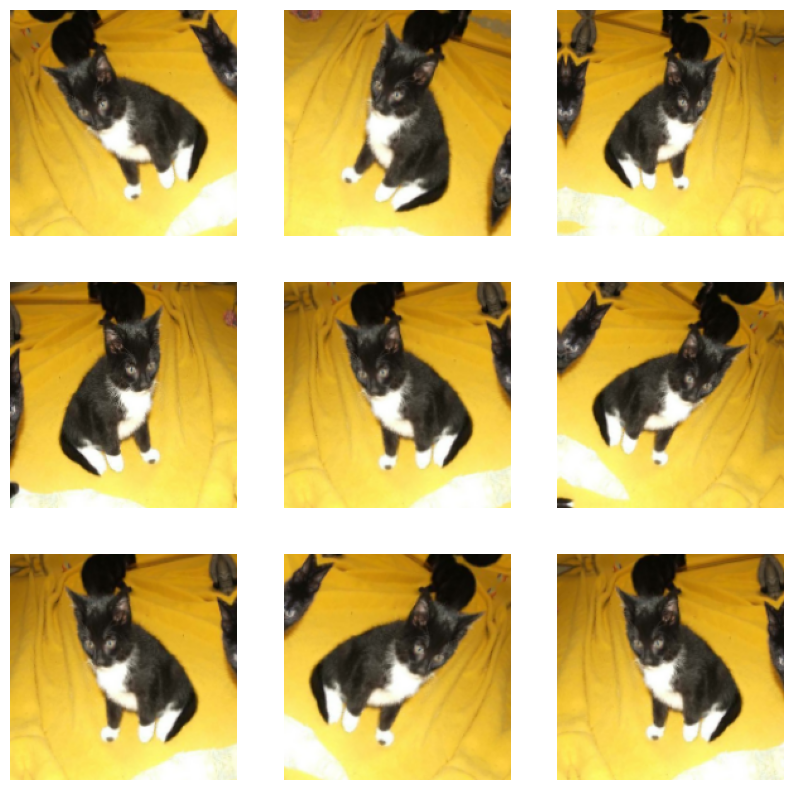

32/32 [==============================] - 3s 48ms/step - loss: 0.0395 - accuracy: 0.9860
Test accuracy: 0.986


In [26]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the MobileNetV2 convolutional base
conv_base  = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_2 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_2.x",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model_pre_trained_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()


# Evaluate the model on the test set
test_model = keras.models.load_model("convnet_from_scratch_2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


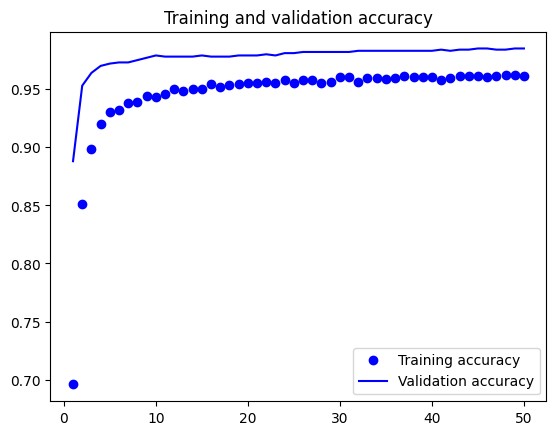

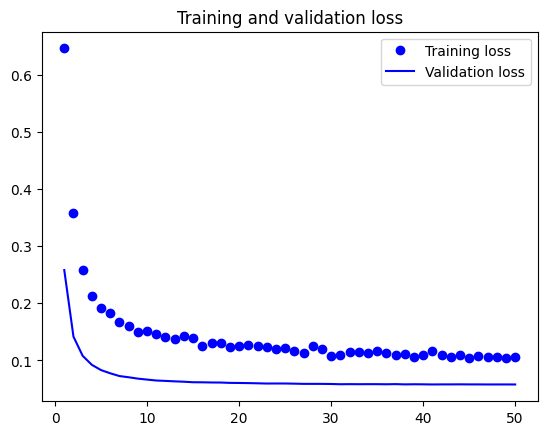

In [27]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()